# Face Mask Evasion Example (part 2)
### _Adversarial Robustness_ Workshop for ML Conference 2022 
#### (scheduled for December 1st, 2022 1:30 PM CEST)
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Github](https://github.com/smasis001))

This notebook will walk through:



- Certifying Adversarial Robustness

## The Preparations

### Installing the Libraries

In [ ]:
#!pip install --upgrade numpy

In [ ]:
#!pip install --upgrade scikit-learn

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
#!pip install --upgrade matplotlib

In [ ]:
#!pip install --upgrade seaborn

In [ ]:
!pip install --upgrade numpy scikit-learn tensorflow matplotlib seaborn
!pip install --upgrade machine-learning-datasets
!pip install adversarial-robustness-toolbox==1.12.2

### Loading the Libraries

In [1]:
%%time
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import machine_learning_datasets as mldatasets
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

from art.estimators.classification import TensorFlowV2Classifier
from art.estimators.certification.randomized_smoothing import TensorFlowV2RandomizedSmoothing
from art.utils import compute_accuracy

pip install 'aif360[LawSchoolGPA]'


CPU times: user 9.55 s, sys: 1.97 s, total: 11.5 s
Wall time: 13 s


### Preparing the Data

In [2]:
X_train, X_test, y_train, y_test =\
                                    mldatasets.load("maskedface-net_thumbs_sampled", prepare=True)
X_train, X_test = X_train / 255.0, X_test / 255.0
min_ = X_train.min()
max_ = X_train.max()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/maskedface-net_thumbs_sampled.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/mlconf-2022/notebooks/data/maskedface-net_thumbs_sampled.zip
/Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/mlconf-2022/notebooks/data/maskedface-net_thumbs_sampled.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/mlconf-2022/notebooks/data/maskedface-net_thumbs_sampled
21000 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/mlconf-2022/notebooks/data/maskedface-net_thumbs_sampled folder


In [3]:
print('X_train dim:\t%s' % (X_train.shape,))
print('X_test dim:\t%s' % (X_test.shape,))
print('y_train dim:\t%s' % (y_train.shape,))
print('y_test dim:\t%s' % (y_test.shape,))
print('X_train min:\t%s' % (min_))
print('X_train max:\t%s' % (max_))
print('y_train labels:\t%s' % (np.unique(y_train)))

X_train dim:	(16800, 128, 128, 3)
X_test dim:	(4200, 128, 128, 3)
y_train dim:	(16800, 1)
y_test dim:	(4200, 1)
X_train min:	0.0
X_train max:	1.0
y_train labels:	['Correct' 'Incorrect' 'None']


In [4]:
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y_train)
labels_l = ohe.categories_[0].tolist()
print(labels_l)

['Correct', 'Incorrect', 'None']


In [5]:
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [6]:
sampl_md_idxs = np.random.choice(X_test.shape[0], 200, replace=False)
X_test_mdsample = X_test[sampl_md_idxs].astype(np.float32)
y_test_mdsample = y_test[sampl_md_idxs]

## Evaluating and Certifying Adversarial Robustness

### Certifying robustness with randomized smoothing
***Optional: takes 1-5 hours***

What if you want to guarantee robustness. Then here I give you an example of a certification method. But it's even more than that too, because it also trains a robust model! Previously, we saw how smoothing can foil adversarial noise, but you have to apply this in the preprocessing stage, not to mention you have to figure out how much to apply so that it's effective. Randomized Smoothing employs this smoothing principle by constructing a "smoothed" classifier from a base classifier. 

To train a smoothed classifier, we must first define a base classifier and all its training parameters. To that end, we need to initialize some standard parameters such as the number of epochs (`nb_epochs`), `batch_size`, the gradient descent optimization algorithm (`optimizer`), and the loss function (`loss_object`). Randomized smoothing also needs to know the number of classes (`nb_classes`) and the sample size (`sample_size`), which is how many perturbed instances it should create per example. We next have to change our training and test datasets to be float32 instead of float64. It will also be useful to make a one-hot encoded version of our labels so that it's easier to plug them into training (`y_train_ohe`) and evaluation (`y_test_mdsample_ohe`) functions without having to transform them every time.

In [7]:
%%time
nb_epochs = 10
batch_size = 128
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss_object = tf.keras.losses.CategoricalCrossentropy()
nb_classes = len(np.unique(y_train))
sample_size = 100

X_train, X_test_mdsample = X_train.astype(np.float32), X_test_mdsample.astype(np.float32)
y_train_ohe = ohe.transform(y_train).astype(np.float32)
y_test_mdsample_ohe = ohe.transform(y_test_mdsample).astype(np.float32)

CPU times: user 2.57 s, sys: 12.3 s, total: 14.9 s
Wall time: 1min 7s


Let's now make a simple function, `get_model`, which returns an untrained base model. It has the same architecture of the previously used base model in part 1.

In [8]:
def get_model(input_shape, min_, max_):
    test_model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(768, activation='relu'),
        Dropout(0.35),
        Dense(3, activation='softmax')
    ])
    
    return test_model

Next, we define a train_step function that applies gradient updates to `trainable_variables` given the `model`, `images`, and `labels`. It leverages the previously defined `loss_object` function to compute the loss, and `optimizer` to apply the gradients, as illustrated in the following code snippet:

In [9]:
def train_step(model, images, labels):        
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

The following function, train_rs_classifier, initializes and trains a smooth classifier using ART's `TensorFlowV2RandomizedSmoothing` estimator. If sigma ($\sigma$) is zero, which means there's no variance in the intended Gaussian noise, it also can construct an unsmoothed classifier with `TensorFlowV2Classifier` and place it in `TensorFlowV2RandomizedSmoothing` so that it can be certified with `sigma_cert`. The function takes training data (`X_train`, `y_train`) and all the parameters we had previously initialized. It also defaults the `alpha` threshold for abstaining predictions at 0.001

In [10]:
def train_rs_classifier(X_train, y_train, nb_epochs, batch_size, min_, max_,\
                        nb_classes, sample_size, loss_object, train_step, sigma=0, sigma_cert=0.5,\
                        alpha=0.001):
    
    input_shape = X_train.shape[1:]
    if sigma > 0:
        rs_classifier = TensorFlowV2RandomizedSmoothing(model=get_model(input_shape, min_, max_),\
                                                        input_shape=input_shape,\
                                                        clip_values=(min_, max_),\
                                                        nb_classes=nb_classes,\
                                                        sample_size=sample_size,\
                                                        loss_object=loss_object,\
                                                        train_step=train_step,\
                                                        scale=sigma, alpha=alpha,\
                                                        channels_first=False)
        
        rs_classifier.fit(X_train, y_train, nb_epochs=nb_epochs, batch_size=batch_size)
        
        return rs_classifier
    else:
        classifier = TensorFlowV2Classifier(model=get_model(input_shape, min_, max_),\
                                                input_shape=input_shape,\
                                                clip_values=(min_, max_),\
                                                nb_classes=nb_classes,\
                                                loss_object=loss_object,\
                                                train_step=train_step,\
                                                channels_first=False)
        
        classifier.fit(X_train, y_train, nb_epochs=nb_epochs, batch_size=batch_size)
        
        rs_classifier = TensorFlowV2RandomizedSmoothing(model=classifier.model,\
                                                        input_shape=input_shape,\
                                                        clip_values=(min_, max_),\
                                                        nb_classes=nb_classes,\
                                                        sample_size=sample_size,\
                                                        loss_object=loss_object,\
                                                        train_step=train_step,\
                                                        scale=sigma_cert, alpha=alpha,\
                                                        channels_first=False)
        return classifier, rs_classifier

Now, let's train three classifiers, as follows:

- `classifier_0`: An unsmoothed classifier. Please note that when $\alpha = 0$, the train_rs_classifier function also returns `rs_classifier_0`, which is not a smoothed classifier but the trained unsmoothed certifiable classifier.
- `rs_classifier_1`: A certifiably smoothed classifier, with $\alpha = 0.25$.
- `rs_classifier_2`: A certifiably smoothed classifier, with $\alpha = 0.5$.

The following snippet trains the three classifiers listed previously, using the `train_rs_classifier` function:

In [14]:
%%time
sigma_0 = 0
classifier_0, rs_classifier_0 = train_rs_classifier(X_train, y_train_ohe, nb_epochs,\
                                                    batch_size, min_, max_, nb_classes,\
                                                    sample_size, loss_object, train_step,\
                                                    sigma_0) 

CPU times: user 1h 10min 9s, sys: 33min 11s, total: 1h 43min 20s
Wall time: 32min 36s


In [15]:
%%time
sigma_1 = 0.25
rs_classifier_1 = train_rs_classifier(X_train, y_train_ohe, nb_epochs, batch_size,\
                                      min_, max_, nb_classes, sample_size, loss_object,\
                                      train_step, sigma_1)

100%|██████████| 10/10 [33:52<00:00, 203.27s/it]


CPU times: user 1h 14min 5s, sys: 34min 25s, total: 1h 48min 30s
Wall time: 34min 22s


In [16]:
%%time
sigma_2 = 0.5
rs_classifier_2 = train_rs_classifier(X_train, y_train_ohe, nb_epochs, batch_size,\
                                      min_, max_, nb_classes, sample_size, loss_object,\
                                      train_step, sigma_2)

100%|██████████| 10/10 [46:11<00:00, 277.10s/it]


CPU times: user 1h 28min 36s, sys: 39min 44s, total: 2h 8min 21s
Wall time: 47min 1s


Once we have trained our three classifiers, we can predict on test samples (`X_test_mdsample`) for all of them. This will take more time than usual because it needs to make sure the predictions are robust.

In [17]:
%%time
y_preds_0 = classifier_0.predict(X_test_mdsample)
y_preds_rs_1 = rs_classifier_1.predict(X_test_mdsample)
y_preds_rs_2 = rs_classifier_2.predict(X_test_mdsample)


CPU times: user 7min 44s, sys: 3min 43s, total: 11min 28s
Wall time: 4min 25s


With the predictions, we can now gauge predictive performance for all three classifiers, with compute_accuracy. A useful feature of this function is that it returns accuracy and coverage. Coverage is what percentage of the predictions were made—in other words, what percentage it didn't abstain—and accuracy is computed only over predictions it did make.

In [18]:
%%time
acc_0, cov_0 = compute_accuracy(y_preds_0, y_test_mdsample_ohe)
acc_rs_1, cov_rs_1 = compute_accuracy(y_preds_rs_1, y_test_mdsample_ohe)
acc_rs_2, cov_rs_2 = compute_accuracy(y_preds_rs_2, y_test_mdsample_ohe)

print("Original Classifier")
print("\tAccuracy: %.2f%%\tCoverage: %.2f%%" % (acc_0*100, cov_0*100))

print("\nSmoothed Classifier (σ=%.2f)" % (sigma_1))
print("\tAccuracy: %.2f%%\tCoverage: %.2f%%" % (acc_rs_1*100, cov_rs_1*100))

print("\nSmoothed Classifier (σ=%.2f)" % (sigma_2))
print("\tAccuracy: %.2f%%\tCoverage: %.2f%%" % (acc_rs_2*100, cov_rs_2*100))

Original Classifier
	Accuracy: 100.00%	Coverage: 100.00%

Smoothed Classifier (σ=0.25)
	Accuracy: 38.00%	Coverage: 100.00%

Smoothed Classifier (σ=0.50)
	Accuracy: 100.00%	Coverage: 99.50%
CPU times: user 4.15 ms, sys: 4.95 ms, total: 9.1 ms
Wall time: 19.6 ms


With only 100 samples and evaluated against 200 images, all three classifiers aren't too far
off from each other. The smoothed classifier reports a 100% accuracy but with 99.5%, which suggests one image is particularly hard to classify. It's likely the same one the unsmoothed classifier misclassified. The $\alpha = 0.5$ smoothed classifier reduces accuracy, suggesting that an increase in noise pushed another image into being misclassified.

These results seem very promising, but we haven't actually stress-tested the classifiers. We do this with certify, except this time we increase the number of samples to 500 (n). This function returns predictions and corresponding radiuses for each prediction, as illustrated in the following code snippet:

In [19]:
%%time
predictions_0, radiuses_0 = rs_classifier_0.certify(X_test_mdsample, n=500)
predictions_1, radiuses_1 = rs_classifier_1.certify(X_test_mdsample, n=500)
predictions_2, radiuses_2 = rs_classifier_2.certify(X_test_mdsample, n=500)

CPU times: user 1h 10min 14s, sys: 34min 24s, total: 1h 44min 39s
Wall time: 42min 45s


How do we leverage the radiuses to certify accuracy? We must use the radiuses as thresholds, measuring the percentage of predictions above a radius threshold that remain correct. We can create a function to this effect (`calc_cert_accuracy`). This takes a list of radius thresholds to test (`radius_list`), the results of a model certification process (`predictions`, `radiuses`), and labels (`y_test`) to test the prediction against.
The code for this can be seen in the following snippet:

In [20]:
def calc_cert_accuracy(radius_list, predictions, radiuses, y_test):
    
    cert_accuracy = []
    nb_certs = len(radiuses)
    
    for r in radius_list:
        r_idx = np.where(radiuses >= r)[0]
        y_test_subset = y_test[r_idx]
        cert_accuracy_r = np.sum(predictions[r_idx] == np.argmax(y_test_subset, axis=1)) / nb_certs
        cert_accuracy.append(cert_accuracy_r)
        
    return cert_accuracy

We will now plot a line chart with radius thresholds to test in the x axis and corresponding certified accuracy in the `y` axis for all three classifiers. We will test 151 radiuses (`radius_list`) between 0 and 1.5 (spaced evenly at 0.01), and then use `calc_cert_accuracy` to calculate the certified accuracy for the three classifiers. The rest of the code is simply plotting these against the `radius_list`, as illustrated in the following
code snippet:

In [21]:
%%time
radius_list = np.linspace(0, 1.5, 151)
cert_accuracy_0 = calc_cert_accuracy(radius_list, predictions_0,\
                                     radiuses_0, y_test_mdsample_ohe)
cert_accuracy_1 = calc_cert_accuracy(radius_list, predictions_1,\
                                     radiuses_1, y_test_mdsample_ohe)
cert_accuracy_2 = calc_cert_accuracy(radius_list, predictions_2,\
                                     radiuses_2, y_test_mdsample_ohe)

CPU times: user 12.1 ms, sys: 5.85 ms, total: 17.9 ms
Wall time: 29.7 ms


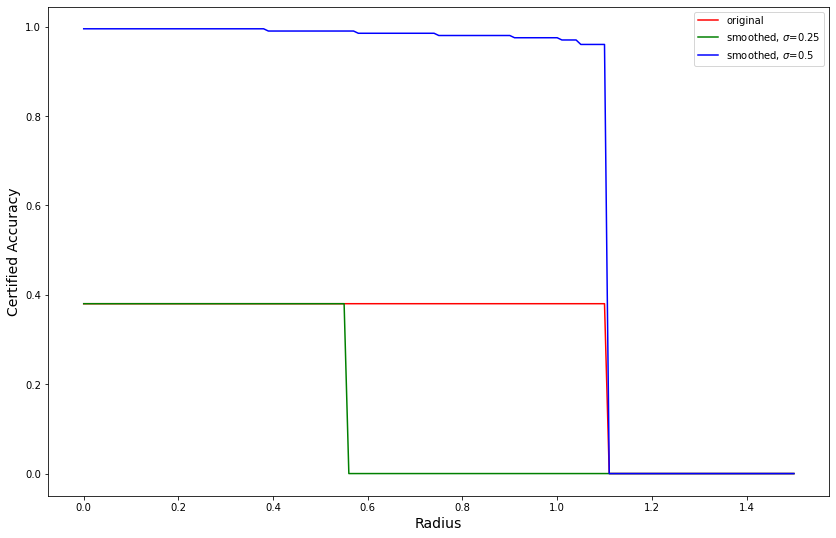

In [22]:
plt.figure(figsize=(14,9))
plt.plot(radius_list, cert_accuracy_0, 'r-', label='original')
plt.plot(radius_list, cert_accuracy_1,\
         '-', color='green', label='smoothed, $\sigma$=' + str(sigma_1))
plt.plot(radius_list, cert_accuracy_2,\
         '-', color='blue', label='smoothed, $\sigma$=' + str(sigma_2))
plt.xlabel('Radius', fontsize=14)
plt.ylabel('Certified Accuracy', fontsize=14)
plt.legend()
plt.show()

## Read More

- [Cohen, J.M., Rosenfeld, E., & Kolter, J.Z. (2019). Certified Adversarial Robustness via Randomized Smoothing. ICML.](https://arxiv.org/abs/1902.02918)